Visualizing Customer Segments using a Self-Organizing Map (SOM)


In [2]:
# Cell 1 - install & imports
!pip install minisom --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from collections import Counter

plt.style.use('seaborn-v0_8')


In [3]:
# Cell 2 - load dataset (working URL)
url = "https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Datasets/Mall_Customers.csv"
data = pd.read_csv(url)
print("Rows, columns:", data.shape)
data.head()


Rows, columns: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# Cell 3 - quick EDA
print(data.info())
print(data.describe())

# Show gender counts
print("\nGender counts:\n", data['Gender'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

In [5]:
# Cell 4 - pick features and normalize
# We'll use Annual Income and Spending Score (classic and very visual).
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = data[features].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Cell 5 - initialize and train SOM
som_x, som_y = 12, 12   # slightly larger grid for nicer visuals
som = MiniSom(x=som_x, y=som_y, input_len=X_scaled.shape[1],
              sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)

som.random_weights_init(X_scaled)
som.train_random(X_scaled, num_iteration=2000)   # 2k iterations
print("SOM training completed.")


SOM training completed.


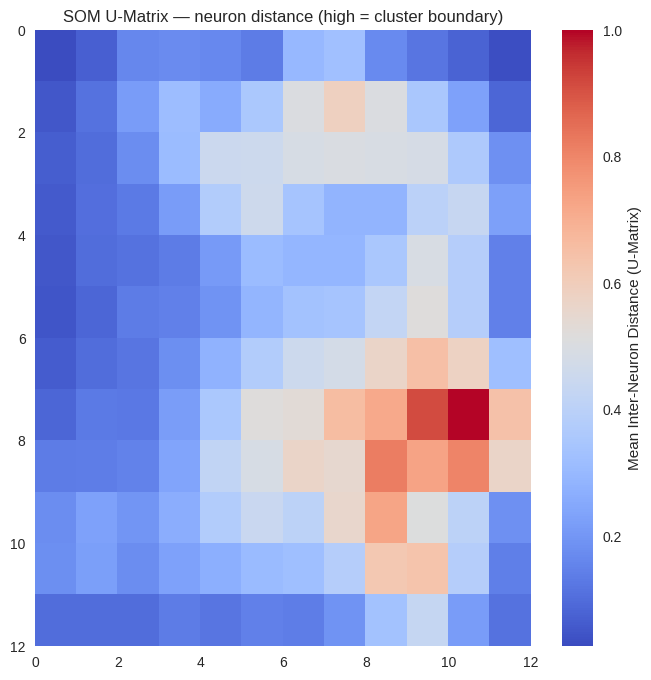

In [7]:
# Cell 6 - distance map (U-Matrix) heatmap
plt.figure(figsize=(8,8))
umatrix = som.distance_map().T  # transpose so axis align with plotting
plt.pcolor(umatrix, cmap='coolwarm')
plt.colorbar(label='Mean Inter-Neuron Distance (U-Matrix)')
plt.title('SOM U-Matrix — neuron distance (high = cluster boundary)')
plt.gca().invert_yaxis()
plt.show()


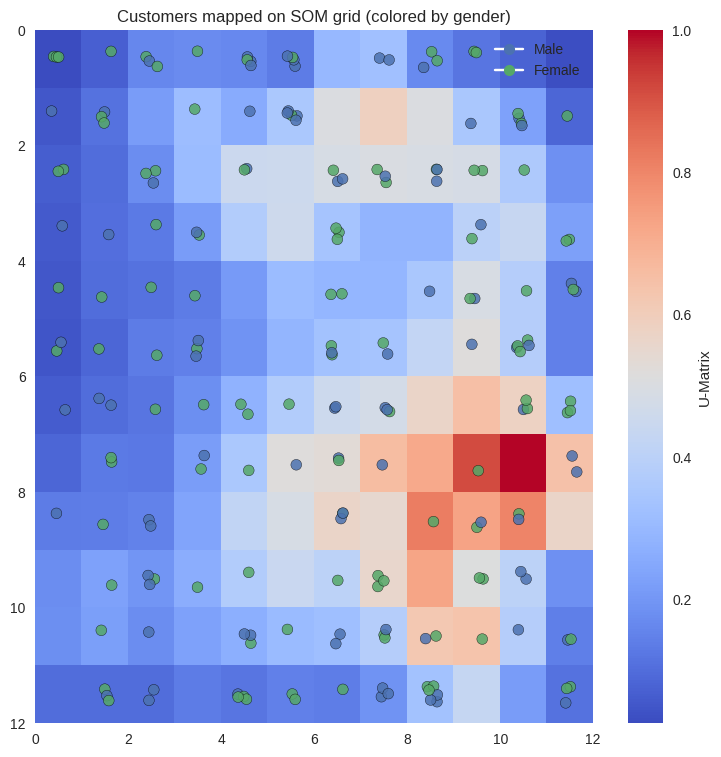

In [8]:
# Cell 7 - map samples to winning neurons and overlay points
win_positions = np.array([som.winner(x) for x in X_scaled])

# Plot U-matrix and overlay customer points
plt.figure(figsize=(9,9))
plt.pcolor(umatrix, cmap='coolwarm')
plt.colorbar(label='U-Matrix')
plt.title('Customers mapped on SOM grid (colored by gender)')

# Color by gender
gender_colors = {'Male':'C0', 'Female':'C1'}
gcols = [gender_colors[g] for g in data['Gender']]

# scatter with small jitter so overlapping points show up better
jitter = 0.3
x_coords = win_positions[:,0] + 0.5 + (np.random.rand(len(win_positions)) - 0.5)*jitter
y_coords = win_positions[:,1] + 0.5 + (np.random.rand(len(win_positions)) - 0.5)*jitter

plt.scatter(x_coords, y_coords, s=60, c=gcols, alpha=0.85, edgecolor='k', linewidth=0.3)
plt.gca().invert_yaxis()
plt.legend(handles=[plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='C0', label='Male', markersize=8),
                    plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='C1', label='Female', markersize=8)],
           loc='upper right')
plt.show()


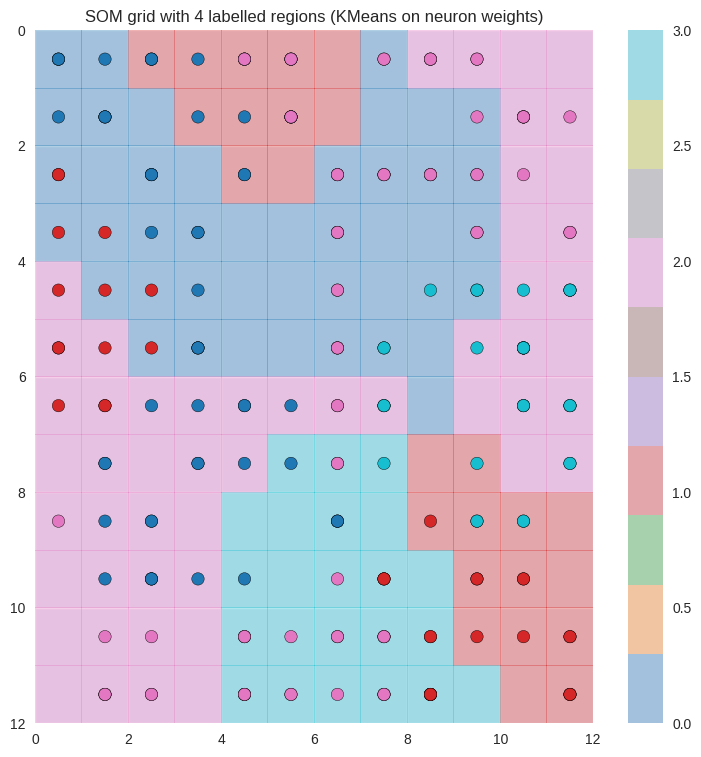

In [9]:
# Cell 8 - automatic grouping: cluster neuron weight vectors using KMeans (labels for regions)
# This groups neurons into, say, 4 major segments; adjust n_clusters for more/fewer groups.
neuron_weights = som.get_weights().reshape(som_x*som_y, -1)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42).fit(neuron_weights)
neuron_labels = kmeans.labels_.reshape(som_x, som_y).T  # transpose to match plotting

# Plot SOM with cluster regions
plt.figure(figsize=(9,9))
plt.pcolor(neuron_labels, cmap='tab10', alpha=0.35)  # lightly shade regions
plt.colorbar()
plt.title(f'SOM grid with {k} labelled regions (KMeans on neuron weights)')
plt.gca().invert_yaxis()

# overlay points with small markers colored by their neuron-region label
sample_region_labels = [neuron_labels[pos[0], pos[1]] for pos in win_positions]  # pos matches transposed mapping
plt.scatter(win_positions[:,0]+0.5, win_positions[:,1]+0.5, c=sample_region_labels, cmap='tab10', s=80, edgecolor='k')
plt.show()


In [10]:
# Cell 9 - interpret cluster centroids (map KMeans centroid back to feature scale)
centroids = kmeans.cluster_centers_
centroids_rescaled = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids_rescaled, columns=features)
centroids_df['Region'] = range(1, k+1)
centroids_df


,Annual Income (k$),Spending Score (1-100),Region
0,44.867084,36.097946,1
1,85.925505,22.487272,2
2,47.181802,60.487918,3
3,89.841101,76.567126,4


In [11]:
# Cell 10 - label regions manually using centroid meaning (example)
# Inspect centroids_df and then write descriptions manually; here's a template print:
for i,row in centroids_df.iterrows():
    print(f"Region {row['Region']}: Annual Income ≈ {row['Annual Income (k$)']:.1f}, Spending Score ≈ {row['Spending Score (1-100)']:.1f}")


Region 1.0: Annual Income ≈ 44.9, Spending Score ≈ 36.1
Region 2.0: Annual Income ≈ 85.9, Spending Score ≈ 22.5
Region 3.0: Annual Income ≈ 47.2, Spending Score ≈ 60.5
Region 4.0: Annual Income ≈ 89.8, Spending Score ≈ 76.6
